# PyMultinest Retrieval

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['CBLAS_NUM_THREADS'] = '1'
import numpy as np
import matplotlib.pyplot as plt
import pickle
from spectres import spectres
from multiprocessing import Pool
import pymultinest


from POSEIDON.core import create_star, wl_grid_constant_R
from POSEIDON.constants import R_Sun
from POSEIDON.core import create_planet
from POSEIDON.constants import R_J, M_J
from POSEIDON.core import define_model
from POSEIDON.core import make_atmosphere
from POSEIDON.core import compute_spectrum


#***** Wavelength grid *****#
wl = wl_grid_constant_R(0.5, 7.5, 10000)

#***** Define stellar properties *****#

R_s = 2.047233*R_Sun     # Stellar radius (m)
T_s = 6000.0         # Stellar effective temperature (K)
Met_s = -0.1          # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.50        # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, wl = wl, stellar_grid = 'phoenix')

#***** Define planet properties *****#

planet_name = 'PlanetA'  # Planet name used for plots, output files etc.

R_p = 0.710185*R_J     # Planetary radius (m)
g_p = 36.374807         # Gravitational field of planet (m/s^2)

# Create the planet object
planet = create_planet(planet_name, R_p, gravity = g_p,)

path_gsoc_data = '/home/exolab/GSoC/POS_Data/100k/'
# Load dataset, pre-load instrument PSF and transmission function
planetA_syn_data = np.load(path_gsoc_data+'planetA_syn_data.npy')

from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'PlanetA_retrieval'  # Model name used for plots, output files etc.

bulk_species = ['H2', 'He']     # H2 + He comprises the bulk atmosphere
param_species = ['H2O','CO2','CO','CH4','NH3']          # The only trace gas is H2O

# Create the model object
model = define_model(model_name, bulk_species, param_species, 
                     PT_profile = 'isotherm', cloud_model = 'Iceberg')

## read opacities from the pickle file

path_gsoc_data = '/home/exolab/GSoC/POS_Data/100k/'
with open(os.path.join(path_gsoc_data, 'opacities.pkl'), 'rb') as f:
    opac = pickle.load(f)

# Specify the pressure grid of the atmosphere
P_min = 1.0e-6    # 1 ubar
P_max = 10       # 10 bar
N_layers = 100    # 100 layers

P_ref = 1.0
R_p_ref = R_p
# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

wl_r100 = wl_grid_constant_R(0.5, 7.5, 100)
wl_r100 = wl_r100[1:-1]

def get_pos_forward_model(params, logX_params):
    PT_params, log_kappa_cloud, log_P_cloud = params
    PT_params = np.array([PT_params])
    cloud_params = [log_kappa_cloud, log_P_cloud]
    atmosphere_full = make_atmosphere(planet, model, P, P_ref, R_p_ref, PT_params, logX_params,cloud_params)
    spectrum_full = compute_spectrum(planet, star, model, atmosphere_full, opac, wl, spectrum_type='transmission')
    binned_spectra_r100 = spectres(wl_r100, wl, spectrum_full, verbose=False)
    return binned_spectra_r100

obs_data = planetA_syn_data[:,1]
obs_err = planetA_syn_data[:,2]

In [2]:
## Define likelihood function

def likelihood(cube,ndim,nparams):
    logH2O,logCO2,logCO,logCH4, logNH3, T, log_kappa_cloud, log_P_cloud = cube[0],cube[1],cube[2],cube[3],cube[4],cube[5],cube[6],cube[7]
    params = T, log_kappa_cloud, log_P_cloud
    logX_params = [logH2O,logCO2,logCO,logCH4,logNH3]
    model_pred = get_pos_forward_model(params, logX_params)

    residual_data = (obs_data - model_pred)
    
    err = obs_err

    norm = -0.5*np.sum(np.log(2.*np.pi*err*err))
    chi2 = np.sum((residual_data**2)/(err**2))
    
    log_likelihood = norm - 0.5 * chi2
        
    return log_likelihood

## Define the priors
def prior(cube,ndim,nparams):

    logH2O_min = -9
    logH20_max = -2

    logCO2_min = -9
    logCO2_max = -2

    logCO_min = -9
    logCO_max = -2

    logCH4_min = -9
    logCH4_max = -2

    logNH3_min = -9
    logNH3_max = -2

    T_min = 500
    T_max = 3500

    log_kappa_cloud_min = -7
    log_kappa_cloud_max = 1

    log_P_cloud_min = -4
    log_P_cloud_max = 1

    cube[0] = cube[0]*(logH20_max - logH2O_min) + logH2O_min
    cube[1] = cube[1]*(logCO2_max - logCO2_min) + logCO2_min
    cube[2] = cube[2]*(logCO_max - logCO_min) + logCO_min
    cube[3] = cube[3]*(logCH4_max - logCH4_min) + logCH4_min
    cube[4] = cube[4]*(logNH3_max - logNH3_min) + logNH3_min
    cube[5] = cube[5]*(T_max - T_min) + T_min
    cube[6] = cube[6]*(log_kappa_cloud_max - log_kappa_cloud_min) + log_kappa_cloud_min
    cube[7] = cube[7]*(log_P_cloud_max - log_P_cloud_min) + log_P_cloud_min


# #### pymultinest run   
nparam = 8
folder = '/home/exolab/GSoC/POS_Data/100k/retrieval/PlanetA/'
if os.path.exists(folder) == False:
    os.mkdir(folder)
pymultinest.run(likelihood,prior,nparam,resume=False,verbose = True,outputfiles_basename = folder,n_live_points = 500)

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    8
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        1.000000
Replacements:                                550
Total Samples:                               550
Nested Sampling ln(Z):             -45023.837991
Importance Nested Sampling ln(Z):    2458.747416 +/-  0.999090
Acceptance Rate:                        0.988468
Replacements:                                600
Total Samples:                               607
Nested Sampling ln(Z):             -29286.882225
Importance Nested Sampling ln(Z):    2458.648805 +/-  0.999176
Acceptance Rate:                        0.973054
Replacements:                                650
Total Samples:                               668
Nested Sampling

In [3]:
import json
params = ['logH20', 'logCO2', 'logCO', 'logCH4', 'logNH3', 'T', 'log_kappa_cloud', 'log_P_cloud']

json.dump(params, open('/home/exolab/GSoC/POS_Data/100k/retrieval/PlanetA/params.json', 'w'))

In [7]:
## creating the corner and trace plots
truths = [-5.929723,-6.081273,-2.733212,-3.873222,-5.411914,2254.645031,-1.356837,-0.43272]
corner_plotting_function('/home/exolab/GSoC/POS_Data/100k/retrieval/PlanetA/',true_values=truths)

  analysing data from /home/exolab/GSoC/POS_Data/100k/retrieval/PlanetA/.txt
  marginal likelihood:
    ln Z = 3073.4 +- 0.0
  parameters:
    logH20         -6.5 +- 1.1
    logCO2         -6.067 +- 0.079
    logCO          -2.72 +- 0.19
    logCH4         -3.861 +- 0.040
    logNH3         -5.36 +- 0.12
    T              2254 +- 28
    log_kappa_cloud-2.8 +- 2.5
    log_P_cloud    -0.450 +- 0.026
creating marginal plot ...


In [10]:
import numpy as np
file_path = '/home/exolab/GSoC/POS_Data/100k/retrieval/PlanetA/stats.json'
   ############ enter folder name
nparam = 8
import json
f = open(file_path)
data = json.load(f)
best_fit = np.zeros(nparam)
for i in range(nparam):
    # best_fit[i] = data["marginals"][i]["median"]
    best_fit[i] = data["modes"][0]["maximum"][i]
logH2O,logCO2,logCO,logCH4, logNH3, T, log_kappa_cloud, log_P_cloud = best_fit
params = T, log_kappa_cloud, log_P_cloud
logX_params = [logH2O,logCO2,logCO,logCH4,logNH3]
best_fit_model = get_pos_forward_model(params, logX_params)
residual_data = (obs_data - best_fit_model)
err = obs_err
chi2 = np.sum((residual_data**2)/(err**2))
dof = len(obs_data) - nparam
rchi2 = chi2/dof

print('reduced chi square is :',rchi2)

reduced chi square is : 0.0036566912282478305


In [12]:
import multiprocessing

output_prefix = '/home/exolab/GSoC/POS_Data/100k/retrieval/PlanetA/'

analyzer = pymultinest.Analyzer(nparam, outputfiles_basename = output_prefix,
                                    verbose = False)
samples = analyzer.get_equal_weighted_posterior()[:,:-1]
N_samples_total = len(samples[:,0])
N_sample_draws = min(N_samples_total, 1000)
sample = np.random.choice(len(samples), N_samples_total, replace=False)
# spectrum_stored = np.zeros(shape=(N_sample_draws, len(obs_wl)))

def calc_depth(i):
    param_vector = samples[sample[i],:]
    logH2O,logCO2,logCO,logCH4, logNH3, T, log_kappa_cloud, log_P_cloud = param_vector
    params = T, log_kappa_cloud, log_P_cloud
    logX_params = [logH2O,logCO2,logCO,logCH4,logNH3]
    spectrum = get_pos_forward_model(params, logX_params)
    # spectrum_stored[i,:] = spectrum
    return spectrum

if __name__ == '__main__':
    num_processors = 4
    with multiprocessing.Pool(num_processors) as pool:
        spec_stored = pool.map(calc_depth, range(N_samples_total))

spec_stored = np.array(spec_stored)

print(np.shape(spec_stored))



(3148, 269)


In [15]:
import numpy as np
import h5py as hp
from spectres import spectres
from mpi4py import MPI
################## significant digits 

def round_sig_figs(value, sig_figs):
    
    ''' Round a quantity to a specified number of significant figures.
    
    '''

    if (value == 0.0):
        return 0.0
    else:
        return round(value, sig_figs - int(np.floor(np.log10(abs(value)))) - 1)
    



def confidence_intervals(sample_draws, array, length, integer=False):     ############# taken directly from poseidon
    
    ''' Order posterior samples to create 1 & 2 sigma contours + median values.
    
    '''
        
    prob = np.empty(sample_draws)
    prob.fill(1.0/sample_draws)
        
    sig_1 = 0.5 + 0.6826/2.0
    sig_2 = 0.5 + 0.954/2.0
    sig_3 = 0.5 + 0.997/2.0
        
    if (length > 0):
            
        arr_low3 = np.zeros(shape=(length))
        arr_low2 = np.zeros(shape=(length))
        arr_low1 = np.zeros(shape=(length))
        arr_median = np.zeros(shape=(length))
        arr_high1 = np.zeros(shape=(length))
        arr_high2 = np.zeros(shape=(length))
        arr_high3 = np.zeros(shape=(length))
            
        for i in range(length):
        
            arr_ordered = list(zip(prob[:], array[:, i]))
            arr_ordered.sort(key=lambda x: x[1])
            arr_ordered = np.array(arr_ordered)
    
            arr_ordered[:,0] = arr_ordered[:,0].cumsum()
    
            arr_ordered_interp = lambda x: np.interp(x, arr_ordered[:,0], arr_ordered[:,1],
                                                     left=arr_ordered[0,1], right=arr_ordered[-1,1])
    
            arr_low3[i] = arr_ordered_interp(1-sig_3)
            arr_low2[i] = arr_ordered_interp(1-sig_2)
            arr_low1[i] = arr_ordered_interp(1-sig_1)
            arr_median[i] = arr_ordered_interp(0.5)
            arr_high1[i] = arr_ordered_interp(sig_1)
            arr_high2[i] = arr_ordered_interp(sig_2) 
            arr_high3[i] = arr_ordered_interp(sig_3) 
            
        return arr_low3, arr_low2, arr_low1, arr_median, arr_high1, arr_high2, arr_high3
            
    if (length == 0):
            
        arr_ordered = list(zip(prob[:], array[:]))
        arr_ordered.sort(key=lambda x: x[1])
        arr_ordered = np.array(arr_ordered)
    
        arr_ordered[:,0] = arr_ordered[:,0].cumsum()
    
        arr_ordered_interp = lambda x: np.interp(x, arr_ordered[:,0], arr_ordered[:,1],
                                                 left=arr_ordered[0,1], right=arr_ordered[-1,1])
            
        if (integer == True):
                
            arr_low3 = np.around(arr_ordered_interp(1-sig_3)).astype(np.int64)
            arr_low2 = np.around(arr_ordered_interp(1-sig_2)).astype(np.int64)
            arr_low1 = np.around(arr_ordered_interp(1-sig_1)).astype(np.int64)
            arr_median = np.around(arr_ordered_interp(0.5)).astype(np.int64)
            arr_high1 = np.around(arr_ordered_interp(sig_1)).astype(np.int64)
            arr_high2 = np.around(arr_ordered_interp(sig_2)).astype(np.int64)
            arr_high3 = np.around(arr_ordered_interp(sig_3)).astype(np.int64)
                
        elif (integer == False):
                
            arr_low3 = arr_ordered_interp(1-sig_3)
            arr_low2 = arr_ordered_interp(1-sig_2)
            arr_low1 = arr_ordered_interp(1-sig_1)
            arr_median = arr_ordered_interp(0.5)
            arr_high1 = arr_ordered_interp(sig_1)
            arr_high2 = arr_ordered_interp(sig_2) 
            arr_high3 = arr_ordered_interp(sig_3) 
                
        return arr_low3, arr_low2, arr_low1, arr_median, arr_high1, arr_high2, arr_high3


In [16]:
_, spec_low2, spec_low1, spec_median, spec_high1, spec_high2, _ = confidence_intervals(N_sample_draws, spec_stored, len(obs_data))

Text(0.5, 1.0, 'PlanetA retrievel')

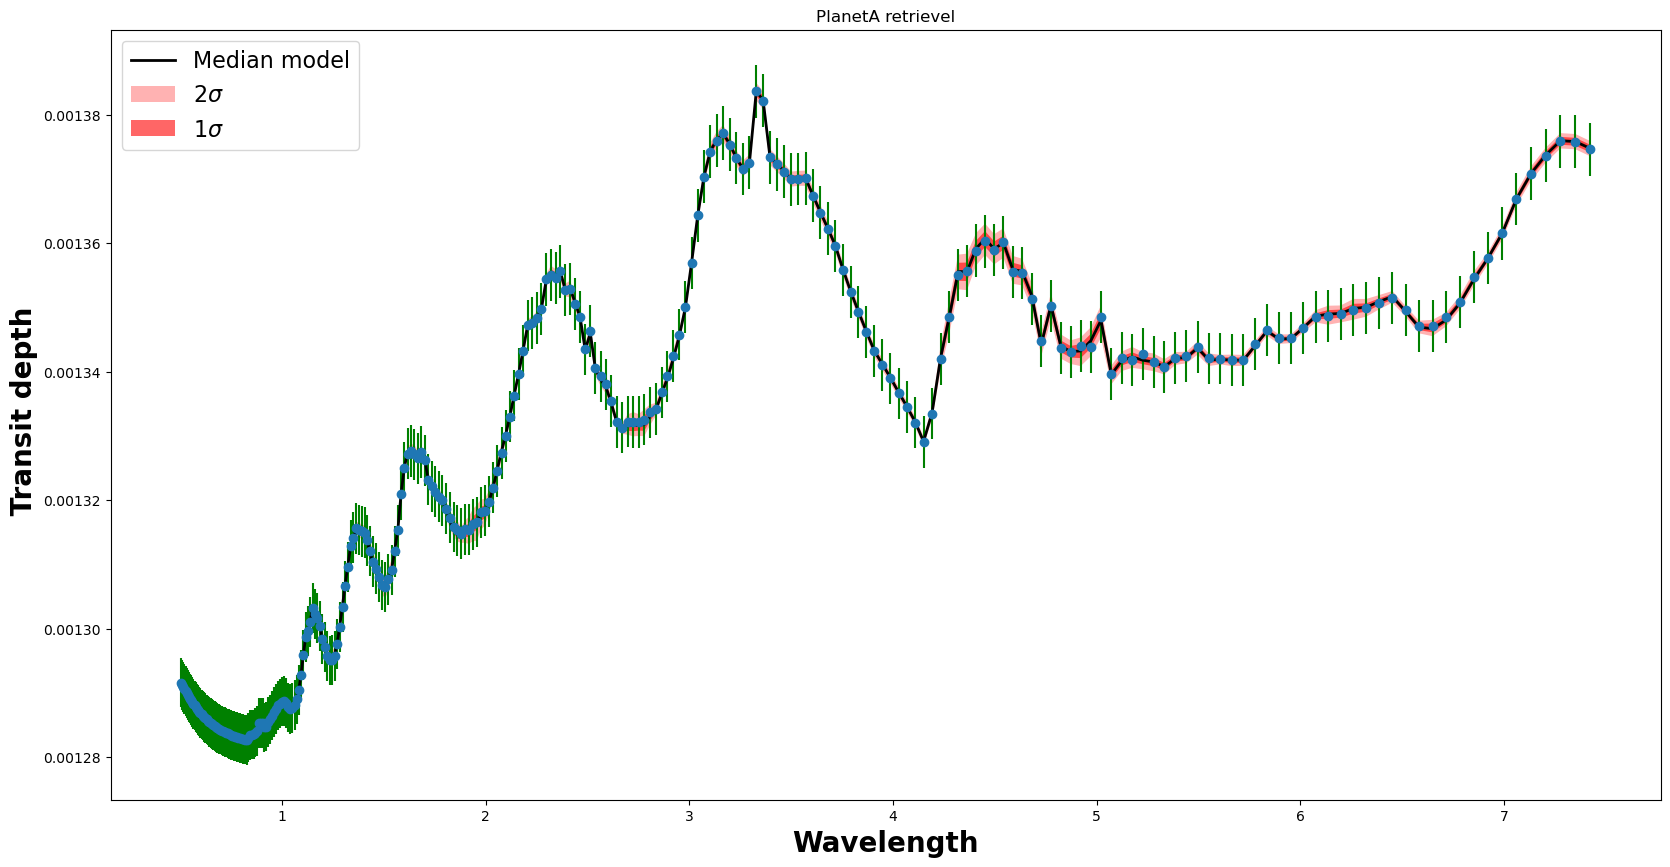

In [18]:
fig1 = plt.figure(figsize=(20,10))
ax1 = plt.axes() 
ax1.plot(wl_r100,spec_median,color='black',linewidth=2.0,
         label = 'Median model')
ax1.errorbar(wl_r100,obs_data,obs_err,ecolor='g',linestyle='',marker = 'o')
ax1.fill_between(wl_r100,spec_low2,spec_high2,  
                facecolor ='red', alpha = 0.3,label = r'$2\sigma$')
ax1.fill_between(wl_r100,spec_low1,spec_high1,
                facecolor ='red', alpha = 0.6,label = r'$1\sigma$')

ax1.legend(loc="upper left",fontsize="16")
ax1.set_xlabel('Wavelength',fontsize=20,fontweight='bold')
ax1.set_ylabel(' Transit depth',fontsize=20,fontweight='bold')
plt.title('PlanetA retrievel')

(0.8, 3.0)

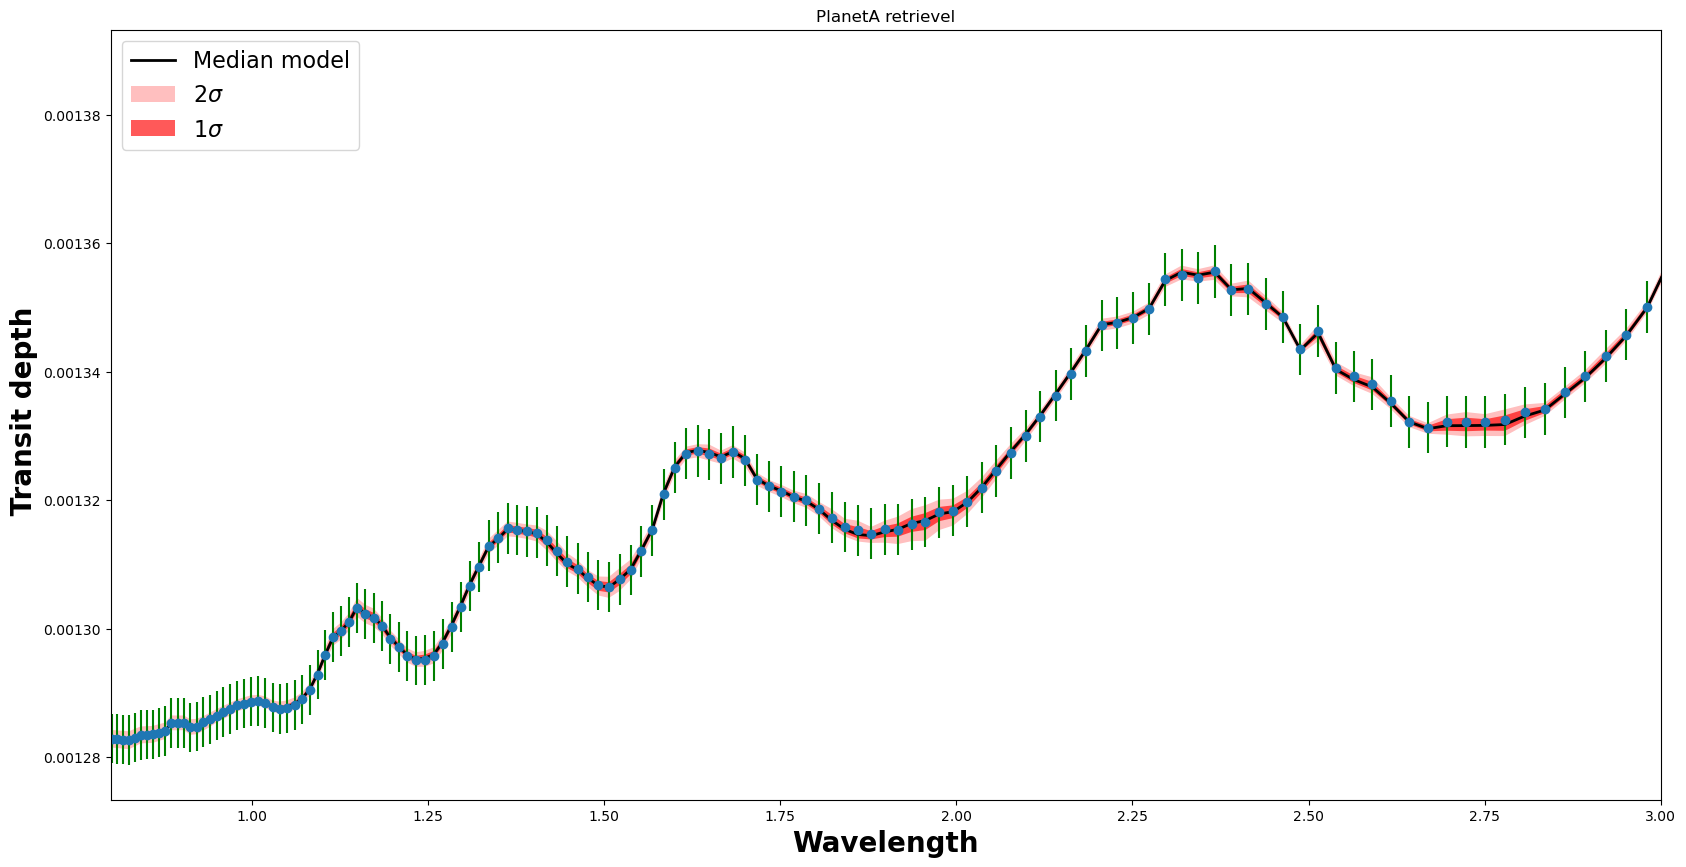

In [23]:
fig1 = plt.figure(figsize=(20,10))
ax1 = plt.axes() 
ax1.plot(wl_r100,spec_median,color='black',linewidth=2.0,
         label = 'Median model')
ax1.errorbar(wl_r100,obs_data,obs_err,ecolor='g',linestyle='',marker = 'o')
ax1.fill_between(wl_r100,spec_low2,spec_high2,  
                facecolor ='red', alpha = 0.25,label = r'$2\sigma$')
ax1.fill_between(wl_r100,spec_low1,spec_high1,
                facecolor ='red', alpha = 0.65,label = r'$1\sigma$')

ax1.legend(loc="upper left",fontsize="16")
ax1.set_xlabel('Wavelength',fontsize=20,fontweight='bold')
ax1.set_ylabel(' Transit depth',fontsize=20,fontweight='bold')
plt.title('PlanetA retrievel')
ax1.set_xlim(0.8,3)
# fig1.savefig(f'{output_prefix}one_two_sigma.jpg',dpi = 400)